## Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import optuna
from sklearn.ensemble import RandomForestRegressor
import vectorbt as vbt

ModuleNotFoundError: No module named 'yfinance'

## Functions

In [ ]:
def pull_data(ticker: str, start_date: str, end_date: str | None) -> pd.DataFrame:
    """
    Pull historical stock data from Yahoo Finance.
    
    Parameters:
    ticker (str): Stock ticker symbol.
    start_date (str): Start date in 'YYYY-MM-DD' format.
    end_date (str): End date in 'YYYY-MM-DD' format.
    
    Returns:
    pd.DataFrame: DataFrame containing historical stock data.
    """
    price_data = yf.download(ticker, start=start_date, end=end_date, interval='1d')    
    if price_data is None:
        raise ValueError("No data found for the given ticker and date range.")
    price_data = price_data[['Close','High','Low','Volume']]
    return price_data

In [ ]:
def calculate_3day_forward_return(price_data: pd.DataFrame) -> pd.DataFrame: # target variable
    """
    Calculate 3-day forward return and add it as a new column.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing stock data with 'Close' prices.
    
    Returns:
    pd.DataFrame: DataFrame with an additional '3day_forward_return' column.
    """
    price_data['3day_forward_return'] = (price_data['Close'].shift(-3) - price_data['Close']) / price_data['Close'] 
    price_data.dropna(inplace=True)
    return price_data

In [ ]:
def calculate_RSI(data: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate Relative Strength Index (RSI) and add it as a new column.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing stock data with 'Close' prices.
    window (int): Window size for RSI calculation.
    
    Returns:
    pd.DataFrame: DataFrame with an additional 'RSI' column.
    """
    close_series = data["Close"].squeeze()
    data["RSI"] = ta.momentum.RSIIndicator(close=close_series, window=window).rsi()
    data.dropna(inplace=True)
    return data
    

In [ ]:
def calculate_MACD(data: pd.DataFrame, window_slow: int = 26, window_fast: int = 12, window_sign: int = 9) -> pd.DataFrame:
    """
    Calculate Moving Average Convergence Divergence (MACD) and add it as a new column.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing stock data with 'Close' prices.
    window_slow (int): Slow EMA window size.
    window_fast (int): Fast EMA window size.
    window_sign (int): Signal line EMA window size.
    
    Returns:
    pd.DataFrame: DataFrame with an additional 'MACD' column.
    """
    close_series = data["Close"].squeeze()
    macd_indicator = ta.trend.MACD(close=close_series, window_slow=window_slow, window_fast=window_fast, window_sign=window_sign)
    data["MACD"] = macd_indicator.macd()
    data["MACD_Signal"] = macd_indicator.macd_signal()
    data["MACD_Diff"] = macd_indicator.macd_diff()
    data.dropna(inplace=True)
    return data

In [ ]:
def calculate_EMA(data: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    close_series = data["Close"].squeeze()
    data['ema_5'] = ta.trend.EMAIndicator(close=close_series, window=5).ema_indicator()
    data['ema_10'] = ta.trend.EMAIndicator(close=close_series, window=10).ema_indicator()
    data['ema_20'] = ta.trend.EMAIndicator(close=close_series, window=20).ema_indicator()
    data['ema_5-20'] = data['ema_5'] - data['ema_20']
    data['slope_ema_10'] = data['ema_10'].diff()
    data.dropna(inplace=True)
    return data

In [ ]:
def calculate_SMA(data: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    close_series = data["Close"].squeeze()
    data['sma'] = ta.trend.SMAIndicator(close=close_series, window=window).sma_indicator()
    return data

In [ ]:
def calculate_ATR(data: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate Average True Range (ATR) and add it as a new column.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing stock data with 'High', 'Low', and 'Close' prices.
    window (int): Window size for ATR calculation.
    
    Returns:
    pd.DataFrame: DataFrame with an additional 'ATR' column.
    """
    close_series = data["Close"].squeeze()
    high_series = data["High"].squeeze()
    low_series = data["Low"].squeeze()
    data['ATR'] = ta.volatility.AverageTrueRange(high=high_series, low=low_series, close=close_series, window=window).average_true_range()
    data.dropna(inplace=True)
    return data

In [ ]:
def calculate_OBV(data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate On-Balance Volume (OBV) and add it as a new column.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing stock data with 'Close' and 'Volume'.
    
    Returns:
    pd.DataFrame: DataFrame with an additional 'OBV' column.
    """
    close_series = data["Close"].squeeze()
    volume_series = data["Volume"].squeeze()
    obv_indicator = ta.volume.OnBalanceVolumeIndicator(close=close_series, volume=volume_series)
    data["OBV"] = obv_indicator.on_balance_volume()
    data.dropna(inplace=True)
    return data

In [ ]:

def calculate_Bollinger_Bands(data: pd.DataFrame, window: int = 20, window_dev: float = 2.0) -> pd.DataFrame:
    """
    Calculate Bollinger Bands %B and Bandwidth.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing stock data with 'Close' prices.
    window (int): Rolling window size.
    window_dev (float): Number of standard deviations for bands.
    
    Returns:
    pd.DataFrame: DataFrame with 'BB_percent' and 'BB_width' columns.
    """
    close_series = data["Close"].squeeze()
    bb_indicator = ta.volatility.BollingerBands(close=close_series, window=window, window_dev=window_dev)
    data["BB_percent"] = bb_indicator.bollinger_pband()
    data["BB_width"] = bb_indicator.bollinger_wband()
    data.dropna(inplace=True)
    return data

In [ ]:

def calculate_MFI(data: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate Money Flow Index (MFI) and add it as a new column.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing stock data with 'High', 'Low', 'Close', and 'Volume'.
    window (int): Window size for MFI.
    
    Returns:
    pd.DataFrame: DataFrame with an additional 'MFI' column.
    """
    mfi_indicator = ta.volume.MFIIndicator(
        high=data["High"].squeeze(),
        low=data["Low"].squeeze(),
        close=data["Close"].squeeze(),
        volume=data["Volume"].squeeze(),
        window=window
    )
    data["MFI"] = mfi_indicator.money_flow_index()
    data.dropna(inplace=True)
    return data

In [ ]:
def calculate_Stochastic_Oscillator(data: pd.DataFrame, window: int = 14, smooth_window: int = 3) -> pd.DataFrame:
    """
    Calculate Stochastic Oscillator (%K and %D).
    
    Parameters:
    data (pd.DataFrame): DataFrame containing stock data with 'High', 'Low', and 'Close'.
    window (int): Lookback window for highest high and lowest low.
    smooth_window (int): Smoothing window for %D line.
    
    Returns:
    pd.DataFrame: DataFrame with 'Stoch_%K' and 'Stoch_%D' columns.
    """
    stoch = ta.momentum.StochasticOscillator(
        high=data["High"].squeeze(),
        low=data["Low"].squeeze(),
        close=data["Close"].squeeze(),
        window=window,
        smooth_window=smooth_window
    )
    data["Stoch_%K"] = stoch.stoch()
    data["Stoch_%D"] = stoch.stoch_signal()
    data.dropna(inplace=True)
    return data

In [ ]:
def calculate_CCI(data: pd.DataFrame, window: int = 20, constant: float = 0.015) -> pd.DataFrame:
    """
    Calculate Commodity Channel Index (CCI).
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'High', 'Low', 'Close'.
    window (int): Window size for typical price mean and std.
    constant (float): Constant to scale mean deviation.
    
    Returns:
    pd.DataFrame: DataFrame with a 'CCI' column.
    """
    cci = ta.trend.CCIIndicator(
        high=data["High"].squeeze(),
        low=data["Low"].squeeze(),
        close=data["Close"].squeeze(),
        window=window,
        constant=constant
    )
    data["CCI"] = cci.cci()
    data.dropna(inplace=True)
    return data

In [ ]:

def calculate_Chaikin_Money_Flow(data: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    """
    Calculate Chaikin Money Flow (CMF).
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'High', 'Low', 'Close', and 'Volume'.
    window (int): Window size for accumulation/distribution.
    
    Returns:
    pd.DataFrame: DataFrame with 'CMF' column.
    """
    cmf = ta.volume.ChaikinMoneyFlowIndicator(
        high=data["High"].squeeze(),
        low=data["Low"].squeeze(),
        close=data["Close"].squeeze(),
        volume=data["Volume"].squeeze(),
        window=window
    )
    data["CMF"] = cmf.chaikin_money_flow()
    data.dropna(inplace=True)
    return data

In [ ]:
def calculate_ADX(data: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate Average Directional Index (ADX).
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'High', 'Low', and 'Close'.
    window (int): Window size for ADX calculation.
    
    Returns:
    pd.DataFrame: DataFrame with 'ADX' column.
    """
    adx = ta.trend.ADXIndicator(
        high=data["High"].squeeze(),
        low=data["Low"].squeeze(),
        close=data["Close"].squeeze(),
        window=window
    )
    data["ADX"] = adx.adx()
    data.dropna(inplace=True)
    return data

## Pull Data

In [ ]:
price_data = pull_data('AAPL', '2024-01-01', None)

/var/folders/lk/3pq871vd3kz43_wvpdd3j3gc0000gn/T/ipykernel_861/1436903007.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


## Feature Engineering

In [ ]:
price_data = calculate_3day_forward_return(price_data) # target variable
price_data = calculate_RSI(price_data)
price_data = calculate_MACD(price_data)
price_data = calculate_EMA(price_data)
price_data = calculate_SMA(price_data)
price_data = calculate_ATR(price_data)
price_data = calculate_OBV(price_data)
price_data = calculate_Bollinger_Bands(price_data)
price_data = calculate_MFI(price_data)
price_data = calculate_Stochastic_Oscillator(price_data)
price_data = calculate_CCI(price_data)
price_data = calculate_Chaikin_Money_Flow(price_data)
#price_data = calculate_ADX(price_data)
price_data['previous_close'] = price_data['Close'].shift(1)
price_data.dropna(inplace=True)

## Understanding Data

In [ ]:
price_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 278 entries, 2024-09-05 to 2025-10-14
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (Close, AAPL)            278 non-null    float64
 1   (High, AAPL)             278 non-null    float64
 2   (Low, AAPL)              278 non-null    float64
 3   (Volume, AAPL)           278 non-null    int64  
 4   (3day_forward_return, )  278 non-null    float64
 5   (RSI, )                  278 non-null    float64
 6   (MACD, )                 278 non-null    float64
 7   (MACD_Signal, )          278 non-null    float64
 8   (MACD_Diff, )            278 non-null    float64
 9   (ema_5, )                278 non-null    float64
 10  (ema_10, )               278 non-null    float64
 11  (ema_20, )               278 non-null    float64
 12  (ema_5-20, )             278 non-null    float64
 13  (slope_ema_10, )         278 non-null    float64
 14  (sma, )

In [ ]:
price_data.describe()

Price,Close,High,Low,Volume,3day_forward_return,RSI,MACD,MACD_Signal,MACD_Diff,ema_5,...,ATR,OBV,BB_percent,BB_width,MFI,Stoch_%K,Stoch_%D,CCI,CMF,previous_close
Ticker,AAPL,AAPL,AAPL,AAPL,,,,,,,...,,,,,,,,,,
count,278.000000,278.000000,278.000000,2.780000e+02,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,...,278.000000,2.780000e+02,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000
mean,224.398742,226.618829,221.869506,5.399482e+07,0.002005,53.404626,0.609430,0.560677,0.048753,224.209282,...,5.298734,1.945621e+09,0.557318,11.729091,58.644568,58.029331,58.021399,19.162022,0.078580,224.298227
std,17.344981,16.909099,17.551318,2.758061e+07,0.035905,11.962206,3.772774,3.449991,1.266535,16.555561,...,1.590457,2.679604e+08,0.328756,5.959026,15.464564,29.540478,27.306846,109.679426,0.131149,17.289933
min,171.998993,189.875235,168.796839,2.323470e+07,-0.189513,20.057858,-10.604119,-8.315574,-4.332957,189.242377,...,3.394027,1.477868e+09,-0.319941,3.490388,17.336175,0.717168,5.543199,-287.418646,-0.297212,171.998993
25%,210.960575,213.068404,208.593267,3.951048e+07,-0.014755,45.118040,-1.381769,-1.271373,-0.602323,209.784041,...,4.265997,1.714583e+09,0.318182,7.286939,45.811699,33.149449,35.091354,-54.083220,-0.012919,210.960575
50%,226.371460,228.367185,223.784240,4.674245e+07,0.003316,52.283555,0.778233,0.891813,0.160008,225.884665,...,4.798848,1.941576e+09,0.599318,10.506242,59.426199,62.501721,61.587251,31.242350,0.062019,226.236938
75%,236.440762,238.832504,233.172259,5.681858e+07,0.018496,61.683215,2.771255,2.382026,0.798186,235.200944,...,5.938858,2.154125e+09,0.807881,13.691047,70.362899,85.857648,82.112096,98.450734,0.168729,236.221756
max,258.103729,259.239990,256.718662,3.186799e+08,0.149229,80.923042,7.548993,7.032176,2.900241,256.964992,...,11.574392,2.565093e+09,1.258800,30.554001,88.425430,99.939373,98.044295,275.939375,0.401843,258.103729


In [ ]:
price_data.tail(10)

Price,Close,High,Low,Volume,3day_forward_return,RSI,MACD,MACD_Signal,MACD_Diff,ema_5,...,ATR,OBV,BB_percent,BB_width,MFI,Stoch_%K,Stoch_%D,CCI,CMF,previous_close
Ticker,AAPL,AAPL,AAPL,AAPL,,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2025-10-01,255.449997,258.790009,254.929993,48713900,0.004854,68.855199,7.435327,6.733906,0.701420,254.447275,...,4.685703,2473307300,0.795705,15.907734,85.078627,88.780614,89.722885,95.979875,0.137457,254.630005
2025-10-02,257.130005,258.179993,254.149994,42630200,-0.002528,70.289041,7.436696,6.874464,0.562232,255.341519,...,4.638867,2515937500,0.805452,16.431984,84.932340,93.013455,90.732649,85.522609,0.118401,255.449997
2025-10-03,258.019989,259.239990,253.949997,49155600,0.000155,71.049417,7.424016,6.984375,0.439641,256.234342,...,4.685376,2565093100,0.795425,16.889827,85.112880,94.677129,92.157066,80.232924,0.148152,257.130005
2025-10-06,256.690002,259.070007,255.050003,44664100,-0.010324,68.238854,7.223382,7.032176,0.191206,256.386229,...,4.637849,2520429000,0.738532,16.980094,79.324795,88.711872,92.134152,71.972486,0.149673,258.019989
2025-10-07,256.480011,257.399994,255.429993,31955800,-0.043707,67.782931,6.967120,7.019165,-0.052045,256.417490,...,4.447289,2488473200,0.711051,16.588144,75.027818,87.782294,90.390432,63.012663,0.192414,256.690002
2025-10-08,258.059998,258.519989,256.109985,36496900,-0.040301,69.437503,6.812987,6.977929,-0.164942,256.964992,...,4.301768,2524970100,0.733857,14.904863,80.071314,93.799297,90.097821,67.061423,0.276724,256.480011
2025-10-09,254.039993,258.000000,253.139999,38322000,-0.024681,60.871616,6.293902,6.841124,-0.547221,255.989993,...,4.345927,2486648100,0.605796,13.095424,70.966560,53.237417,78.273003,43.409542,0.222005,258.059998
2025-10-10,245.270004,256.380005,244.000000,61999100,0.016594,47.193711,5.115887,6.496076,-1.380190,252.416663,...,4.919790,2424649000,0.302102,11.788239,59.424352,8.333367,51.790027,-27.940074,0.133487,254.039993


### Correlation Matrix

<Axes: xlabel='Price-Ticker', ylabel='Price-Ticker'>

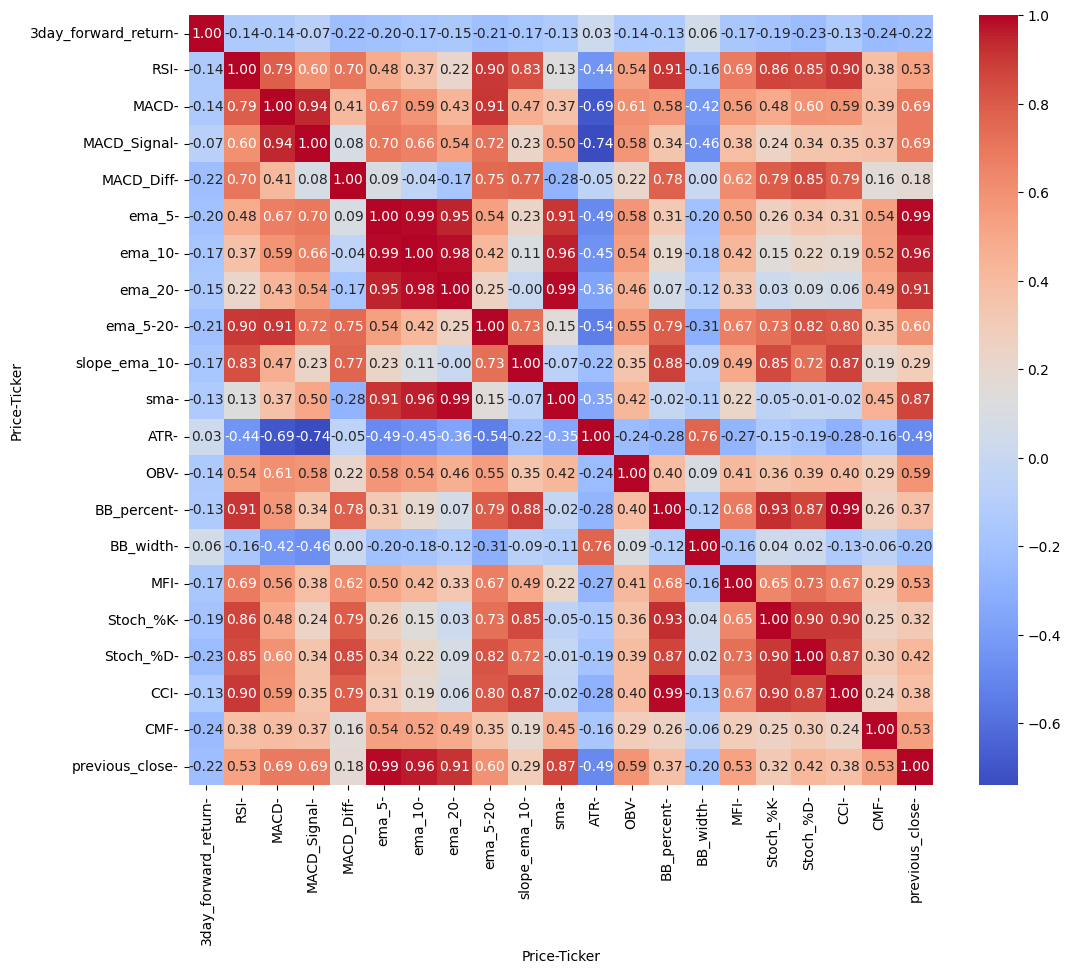

In [ ]:
data = price_data.drop(columns=['Close', 'High', 'Low', 'Volume'])
df_correlation = data.corr()
fig = plt.figure(figsize=(12, 10))
sns.heatmap(df_correlation, annot=True, fmt=".2f", cmap='coolwarm')

In [ ]:
# cleaned data
price_data = price_data[['previous_close','3day_forward_return', 'RSI', 'MACD_Diff', 'ema_5-20', 'sma', 'ATR', 'OBV', 'BB_percent', 'MFI', 'CMF','Stoch_%D']]

<Axes: xlabel='Price-Ticker', ylabel='Price-Ticker'>

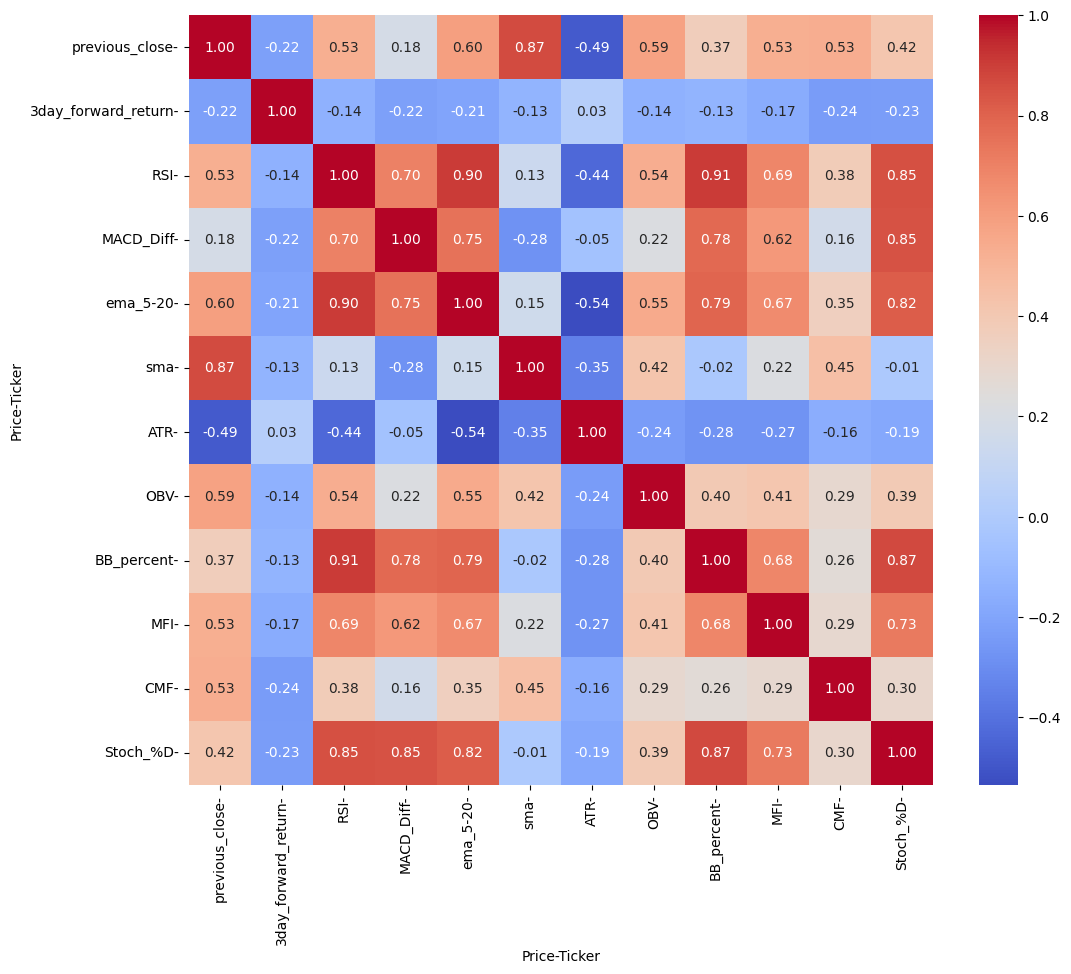

In [ ]:
data = price_data
df_correlation = data.corr()
fig = plt.figure(figsize=(12, 10))
sns.heatmap(df_correlation, annot=True, fmt=".2f", cmap='coolwarm')

## Modelling

In [ ]:

# Assume 'price_data' is your DataFrame with features and the '3day_forward_return' target

# --- Define Hyperparameters for the Rolling Window ---
# Size of the historical data used to train the model (e.g., 6 months of daily data)
TRAIN_WINDOW_DAYS = 126  # Approx. 6 months of trading days (21 * 6)
# Size of the new data block to test/validate on
TEST_WINDOW_DAYS = 21    # Approx. 1 month of trading days
# The columns to exclude from features
TARGET_COLUMN = '3day_forward_return'

# --- The Rolling Window Loop ---
results = []
# Calculate the maximum starting index for the training window
max_train_start_index = len(price_data) - TRAIN_WINDOW_DAYS - TEST_WINDOW_DAYS + 1

# Iterate through the dataset
for i in range(0, max_train_start_index, TEST_WINDOW_DAYS):
    # 1. Define Training Slice
    train_start_idx = i
    train_end_idx = i + TRAIN_WINDOW_DAYS
    train_data = price_data.iloc[train_start_idx:train_end_idx]

    # 2. Define Testing Slice (immediately after training)
    test_start_idx = train_end_idx
    test_end_idx = train_end_idx + TEST_WINDOW_DAYS
    test_data = price_data.iloc[test_start_idx:test_end_idx]

    # --- Prepare X/y splits for this fold ---
    X_train = train_data.drop(columns=[TARGET_COLUMN])
    y_train = train_data[TARGET_COLUMN]
    X_test = test_data.drop(columns=[TARGET_COLUMN])
    y_test = test_data[TARGET_COLUMN]

    # -- Scaling
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Model Training and Testing (Placeholder) ---
    # 1. TRAIN your kNN model here using X_train, y_train

    def objective(trial):
        n_neighbors = trial.suggest_int('n_neighbors', 5, 20)
        weights = trial.suggest_categorical('weights', ['uniform','distance'])
        algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
        leaf_size = trial.suggest_int('leaf_size', 10, 50)
        model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        return r2
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    print("Best hyperparameters: ", study.best_params)
    print("Best R^2: ", study.best_value)

    # train set evaluation

    knn = KNeighborsRegressor(**study.best_params)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    results.append({
        'fold': len(results),
        'mae_test': mae_test,
        'r2_test': r2_test,
        'best_params': study.best_params
    })


print(f"\nCompleted {len(results)} walk-forward folds.")

/var/folders/lk/3pq871vd3kz43_wvpdd3j3gc0000gn/T/ipykernel_861/1637958350.py:29: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

/var/folders/lk/3pq871vd3kz43_wvpdd3j3gc0000gn/T/ipykernel_861/1637958350.py:31: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

[I 2025-10-19 21:26:56,540] A new study created in memory with name: no-name-d350ad9a-bbbf-479c-9af8-09913f624793


[I 2025-10-19 21:26:56,577] Trial 0 finished with value: -0.16464662884800907 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 47}. Best is trial 0 with value: -0.16464662884800907.
[I 2025-10-19 21:26:56,583] Trial 1 finished with value: -0.17662529534439053 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 38}. Best is trial 0 with value: -0.16464662884800907.
[I 2025-10-19 21:26:56,601] Trial 2 finished with value: -0.19731912473317892 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 13}. Best is trial 0 with value: -0.16464662884800907.
[I 2025-10-19 21:26:56,610] Trial 3 finished with value: -0.14456213072148572 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 28}. Best is trial 3 with value: -0.14456213072148572.
[I 2025-10-19 21:26:56,620] Trial 4 finished with value: -0.16111529814548953 and parameters

Best hyperparameters:  {'n_neighbors': 20, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 25}
Best R^2:  -0.10456368272986971


[I 2025-10-19 21:26:57,444] Trial 23 finished with value: -0.06274426697330981 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 19}. Best is trial 10 with value: -0.03852529011278771.
[I 2025-10-19 21:26:57,456] Trial 24 finished with value: -0.11337824341918923 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 22}. Best is trial 10 with value: -0.03852529011278771.
[I 2025-10-19 21:26:57,469] Trial 25 finished with value: -0.03852529011278771 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 13}. Best is trial 10 with value: -0.03852529011278771.
[I 2025-10-19 21:26:57,480] Trial 26 finished with value: -0.08703082158128761 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 17}. Best is trial 10 with value: -0.03852529011278771.
[I 2025-10-19 21:26:57,490] Trial 27 finished with value: -0.11337824341918945 and par

Best hyperparameters:  {'n_neighbors': 20, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 12}
Best R^2:  -0.03852529011278771


[I 2025-10-19 21:26:57,933] Trial 16 finished with value: 0.1342283961075572 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 40}. Best is trial 14 with value: 0.24994097087376999.
[I 2025-10-19 21:26:57,946] Trial 17 finished with value: 0.24994097087376999 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 44}. Best is trial 14 with value: 0.24994097087376999.
[I 2025-10-19 21:26:57,960] Trial 18 finished with value: 0.24994097087376999 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 34}. Best is trial 14 with value: 0.24994097087376999.
[I 2025-10-19 21:26:57,970] Trial 19 finished with value: 0.1342283961075572 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 44}. Best is trial 14 with value: 0.24994097087376999.
[I 2025-10-19 21:26:57,980] Trial 20 finished with value: 0.1579640734491643 and parameters

Best hyperparameters:  {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 42}
Best R^2:  0.24994097087376999


[I 2025-10-19 21:26:58,480] Trial 24 finished with value: -1.3015732824600539 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 36}. Best is trial 6 with value: -1.3015732824600539.
[I 2025-10-19 21:26:58,493] Trial 25 finished with value: -1.7205436948623363 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 44}. Best is trial 6 with value: -1.3015732824600539.
[I 2025-10-19 21:26:58,504] Trial 26 finished with value: -1.5179372313921848 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 50}. Best is trial 6 with value: -1.3015732824600539.
[I 2025-10-19 21:26:58,514] Trial 27 finished with value: -1.6527420572513805 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 43}. Best is trial 6 with value: -1.3015732824600539.
[I 2025-10-19 21:26:58,524] Trial 28 finished with value: -1.5179372313921848 and parameters

Best hyperparameters:  {'n_neighbors': 20, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 34}
Best R^2:  -1.3015732824600539


[I 2025-10-19 21:26:58,948] Trial 17 finished with value: 0.14112325520251368 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 24}. Best is trial 12 with value: 0.16499619221064676.
[I 2025-10-19 21:26:58,961] Trial 18 finished with value: 0.056781421866858084 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 35}. Best is trial 12 with value: 0.16499619221064676.
[I 2025-10-19 21:26:58,971] Trial 19 finished with value: 0.20941813411597388 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 20}. Best is trial 19 with value: 0.20941813411597388.
[I 2025-10-19 21:26:58,982] Trial 20 finished with value: 0.20941813411597388 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 21}. Best is trial 19 with value: 0.20941813411597388.
[I 2025-10-19 21:26:58,991] Trial 21 finished with value: 0.20941813411597388 and p

Best hyperparameters:  {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 20}
Best R^2:  0.20941813411597388


[I 2025-10-19 21:26:59,462] Trial 25 finished with value: 0.1139673399750194 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 15}. Best is trial 0 with value: 0.12342018287646317.
[I 2025-10-19 21:26:59,471] Trial 26 finished with value: 0.12342018287646317 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 23}. Best is trial 0 with value: 0.12342018287646317.
[I 2025-10-19 21:26:59,485] Trial 27 finished with value: 0.11792832532409447 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 44}. Best is trial 0 with value: 0.12342018287646317.
[I 2025-10-19 21:26:59,496] Trial 28 finished with value: 0.06379827839150709 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 29}. Best is trial 0 with value: 0.12342018287646317.
[I 2025-10-19 21:26:59,506] Trial 29 finished with value: -0.2904127138279651 and parameters: {'

Best hyperparameters:  {'n_neighbors': 17, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 15}
Best R^2:  0.12342018287646317


[I 2025-10-19 21:26:59,917] Trial 16 finished with value: -0.340271669579822 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 10}. Best is trial 12 with value: -0.340271669579822.
[I 2025-10-19 21:26:59,934] Trial 17 finished with value: -0.6886203772435111 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 15}. Best is trial 12 with value: -0.340271669579822.
[I 2025-10-19 21:26:59,947] Trial 18 finished with value: -0.4309077061048532 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 15}. Best is trial 12 with value: -0.340271669579822.
[I 2025-10-19 21:26:59,959] Trial 19 finished with value: -0.37579129101382946 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 24}. Best is trial 12 with value: -0.340271669579822.
[I 2025-10-19 21:26:59,969] Trial 20 finished with value: -0.4309077061048532 and parameters: {

Best hyperparameters:  {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 12}
Best R^2:  -0.2492459272975378

Completed 7 walk-forward folds.


In [ ]:
for res in results:
    print(res)

{'fold': 0, 'mae_test': 0.04416747221114108, 'r2_test': -0.10456368272986971, 'best_params': {'n_neighbors': 20, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 25}}
{'fold': 1, 'mae_test': 0.04223158353281033, 'r2_test': -0.03852529011278771, 'best_params': {'n_neighbors': 20, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 12}}
{'fold': 2, 'mae_test': 0.022620687638288877, 'r2_test': 0.24994097087376999, 'best_params': {'n_neighbors': 11, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 42}}
{'fold': 3, 'mae_test': 0.024585665674857753, 'r2_test': -1.3015732824600539, 'best_params': {'n_neighbors': 20, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 34}}
{'fold': 4, 'mae_test': 0.02652927265274029, 'r2_test': 0.20941813411597388, 'best_params': {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 20}}
{'fold': 5, 'mae_test': 0.01898595929331678, 'r2_test': 0.12342018287646317, 'best_params': {'n_neighbors': 17, 'weight

In [ ]:
# Create a DataFrame to store predictions
predictions_df = pd.DataFrame(index=price_data.index)
predictions_df['predicted_return'] = np.nan

# Iterate through the dataset again to store predictions
for i in range(0, max_train_start_index, TEST_WINDOW_DAYS):
    # Define Training and Testing slices
    train_start_idx = i
    train_end_idx = i + TRAIN_WINDOW_DAYS
    test_start_idx = train_end_idx
    test_end_idx = train_end_idx + TEST_WINDOW_DAYS
    
    # Get the data
    train_data = price_data.iloc[train_start_idx:train_end_idx]
    test_data = price_data.iloc[test_start_idx:test_end_idx]
    
    # Prepare and scale the data
    X_train = train_data.drop(columns=[TARGET_COLUMN])
    y_train = train_data[TARGET_COLUMN]
    X_test = test_data.drop(columns=[TARGET_COLUMN])
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train the model with the best parameters from the corresponding fold
    fold_results = results[i // TEST_WINDOW_DAYS]
    knn = KNeighborsRegressor(**fold_results['best_params'])
    knn.fit(X_train, y_train)
    
    # Make predictions for this test window
    y_pred = knn.predict(X_test)
    
    # Store predictions in the predictions DataFrame
    predictions_df.iloc[test_start_idx:test_end_idx, 0] = y_pred

# Add predictions to the original price_data DataFrame
price_data['predicted_return'] = predictions_df['predicted_return']

# Display the first few rows with actual and predicted returns
print("\nFirst few rows with actual and predicted returns:")
print(price_data[['3day_forward_return', 'predicted_return']].head())

## Signal Generation

In [ ]:
def check_metrics() -> bool:
    #entry
    if results[-1]['r2_test'] < 0.2:# or results[-1]['mae_test'] > 0.02:
        return False
    return True

def check_returns() -> bool: 
    return price_data['entry'] > price_data['predicted_return'] > 0.01

def auto_exit(df: pd.DataFrame, hold_period: int) -> pd.DataFrame:
    """Generate exit signals N days after each entry signal."""
    df = df.copy()
    df["exit"] = False

    # Find all entry indices
    entry_indices = df.index[df["entry"] == True]

    for i in entry_indices:
        exit_index = i + hold_period
        # Ensure we don’t go out of bounds
        if exit_index < len(df):
            df.loc[exit_index, "exit"] = True

    return df


In [ ]:
check_returns()
df = auto_exit(price_data, hold_period=3)
df.head()

## Backtesting with Vector BT

In [ ]:
pf = vbt.Portfolio.from_orders(
    close=price_data['previous_close'],
    size=10,
    direction='both',
    freq='1D',
    fees=0.005
)

print(pf.stats().to_frame())
(pf.value().sum(axis=1) / 2).vbt.plot(title="Total Portfolio Value").show()